# Optimal Portfoilio Selection

Project on course "Optimization Methods"

Oleg Gorodnitskii, Dmytro Fedoriaka, Rasul Khasianov

Skoltech, 2017

## Introduction
* **Asset** $-$ an investment instrument that can be bought and sold.
* Suppose we purchase an asset for $x(0)$ dollars on one date and then later sell it for $x(1)$ dollars and there are $N$ risky assets, whose **rates of returns** are given by random Variables $R_1, \dots, R_N$:
$$R_n = \frac{x_n(1) - x_n(0)}{x_n(0)},\; n = 1, \dots, N $$
* Let $w = (w_1, \dots, w_N)^T, \;w_n$ denotes the proportion of wealth invested in asset n. The **rate of return of the portfolio** is $$R_P = \sum_{n=1}^{N} w_nR_n, \text{ where } \sum_{n=1}^N w_n \leq 1 $$
* **The goal**: to choose the portfolio weighting factors **optimally**!

### Markowitz Mean-Variance Analysis
\begin{align}
\mathbb{E} [R] = \sum_{i=1}^N w_i R_i = w^T R&& \mathrm{Var[R]} = \sum_{i=1}^N \sum_{j=1}^N w_i \sigma_{ij} w_j = w^T \Sigma w
\end{align}

For this problem we will see the following results:
![MVA](../data/img1.png)


* A portfolio $w^*$ is said to be **mean-variance efficient** if there exists no portfolio $w$ with $\mu_P \geq \mu^*$ and $\sigma^2_P \leq {\sigma^*}^2$, except itself. That is, you cannot find a portfolio that has a higher return and lower risk than those for an efficient portfolio.
![MVA](../data/img2.png)

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from datetime import datetime
import cvxpy as cvx

In [2]:
# Name of train/test dataset. 'data', 'nyse_each_50','nyse_each_10' or 'nyse'
DATASET_NAME = 'data'

# Period, on which we will invest.
PERIOD = 50

# Set of lambda parameters, which we will check.
LAMBDA_RANGE = [0.01, 0.1, 0.5, 1, 2]

## Dataset: historical 2014 prices for p = 22 securities
![MVA](../data/img3.png)

In [3]:
data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
train_file = os.path.join(data_folder, DATASET_NAME + '_train.csv')
test_file = os.path.join(data_folder, DATASET_NAME + '_test.csv')

In [4]:
# Reading data.
data = pd.read_csv(train_file)

In [5]:
# Extract prices and dates.

sequrity_ids = data.columns[1:]
dates = [datetime.strptime(d, '%Y-%m-%d') for d in data['Date']]
prices = np.array(data[sequrity_ids]).T

# Covariation matrix.
cov = np.corrcoef(prices)

# Number of sequrities.
N = len(sequrity_ids)

# Number of time moments in train data.
T = len(dates) 

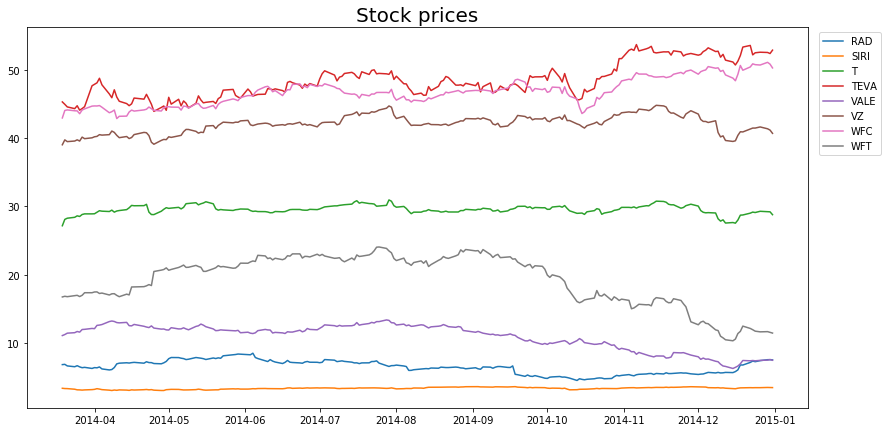

In [6]:
# Visualize some prices.

plt.figure(figsize=(14,7))
seq_to_show = sequrity_ids[-8:]

for seq in seq_to_show:
    plt.plot(dates[-200:], data[seq][-200:], label = seq)
plt.legend( bbox_to_anchor=(1.1, 1))
plt.title("Stock prices", fontsize=20)
plt.show()

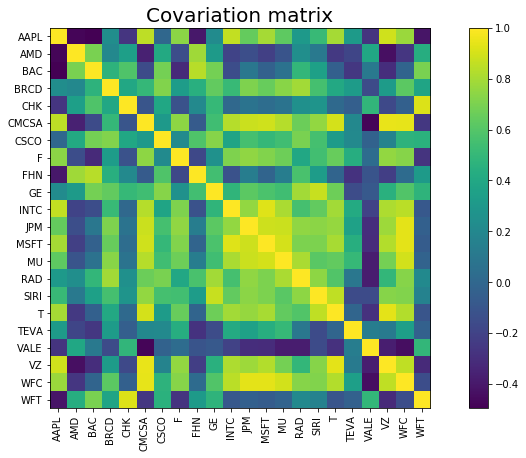

In [7]:
# Visualize covariation matrix.
plt.figure(figsize=(14,7))
plt.imshow(cov, interpolation='none')
plt.colorbar()
plt.xticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='vertical')
plt.yticks(range(len(sequrity_ids)), sequrity_ids, fontsize=10,rotation='horizontal')
plt.title("Covariation matrix", fontsize=20)
plt.show()

# Prediction of future prices
Here we use **ARIMA** (autoregressive integrated moving average) model to predict future points in the series.

In [8]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
import matplotlib.pylab as plt


def test_stationarity(timeseries):
   
    dftest = adfuller(timeseries, autolag='AIC')
    return (dftest[0], dftest[4]['5%'])

def stationarize(timeseries):
    timeseries_log = np.log(timeseries)
    timeseries_log_diff = timeseries_log - timeseries_log.shift()
    timeseries_log_diff.dropna(inplace=True)
    return timeseries_log_diff

def check_stationarity(data):
    for sym in list(data):
        print(test_stationarity(stationarize(data[sym])))
        
    
def predict_on_period(timeseries, period):
    model = ARIMA(timeseries, order=(2, 1, 1))  
    results_ARIMA = model.fit(disp=-1) 
    forecasts = results_ARIMA.forecast(period)
    return forecasts[0]

def pred_arima(data, period):
    
    prices_pred = []
    for sym in list(data):
        timeseries_stat = stationarize(data[sym])
        prices_pred.append(np.sum(predict_on_period(timeseries_stat, period))+np.log(data[sym][-1]))
    
    return np.exp(prices_pred)


def to_ts(data):
    data['Date'] = pd.to_datetime(data['Date'], format = '%Y-%m-%d')
    data_indx = data.set_index('Date')
    return data_indx

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [9]:
# This suppresses warnings.
import warnings
warnings.simplefilter('ignore')

In [10]:
predictions = pred_arima(to_ts(data), PERIOD)
print(predictions)

[ 111.19483209    2.47545427   18.33781726   12.09831891   19.05690535
   29.22375821   26.76849379   13.25465234   13.77302875   24.27441401
   35.06781614   60.64544795   44.7495861    39.11164588    8.86348425
    3.51257157   29.02974031   55.22209835    6.39980701   40.83110099
   53.29811992   10.94869329]


### Results by ARIMA prediction
![MVA](../data/img4.png)

## Optimization
In order to forecast the best protfolio going forward:
\begin{align}
\max_w\; & R w - \lambda w^T \Sigma w\\
s.t. \; &\sum_{i} w_i \leq 1, w_i \geq 0
\end{align}
* The second term means that we penalize for the most risky portfolio

In [11]:
# Calculates profit if we buy sequrities at time_buy, sell them
# at time_sell, spend x[i] part of capital on i-rh security.
# Assumes that initial capital is equal to 1.
def count_profit(prices, date_buy, date_sell, x):    
    prices_at_buy = prices[:, date_buy]
    prices_at_sell = prices[:, date_sell]
    capital_spent = np.sum(x)
    amount_bought = x / prices_at_buy
    revenue = np.dot(amount_bought, prices_at_sell)
    return revenue - np.sum(x)

# Calculates real profit on test data.
test_prices = None
def count_real_profit(portfolio, period):
    global test_prices 
    if test_prices is None:         # This is to ensure we don't read CSV each time we count profit
        data_folder = os.path.join(os.path.dirname(os.getcwd()), 'data')
        test_data_file = os.path.join(data_folder, DATASET_NAME + '_test.csv')
        test_data = pd.read_csv(test_data_file)
        test_prices = np.array(test_data[sequrity_ids]).T
    return count_profit(test_prices, 0, period, portfolio)

# By given profitabilities, cov.matrix and lambda gives optimal portfolio.
def get_optimal_portfolio(r, cov, l):
    x = cvx.Variable(N)
    
    objective = cvx.Maximize(r*x - l*cvx.quad_form(x, cov))
    constraints = [cvx.sum_entries(x) <= 1, x >= 0]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

# prices - numpy.array (N x T) of known prices (N - number of sequritites, T - number of time moments).
# date_buy - index of row in prices, which corresponds to buying date.
# l - 'lambda' parameter in objective.
# predicted_prices - predicted/known prices on day of selling, from external predictor.
#                    Must be arranged in the same order, as columns in prices.
def get_optimal_portfoilio_for_known_predictions(prices, date_buy, l, predicted_prices):
    # Calculating profitabilities.
    r = np.array([
        (predictions[i] - prices[i, date_buy]) / prices[i, date_buy] 
        for i in range(N)
    ])
    cov = np.corrcoef(prices[:,:date_buy+1])
    return get_optimal_portfolio(r, cov, l)

def portfolio_info(portfolio, period):
    plt.figure(figsize=(17,4))
    # Show portfolio as pie chart.
    inv_seq = []
    for i in range(N):
        if portfolio[i] > 1e-5:
            inv_seq.append((opt_portfolio[i], sequrity_ids[i]))
    inv_seq.sort(reverse=True)
    non_zero_inv = len(inv_seq)
    fracs = [inv_seq[i][0] for i in range(non_zero_inv)]
    labels = [inv_seq[i][1] for i in range(non_zero_inv)]
    plt.subplot(1, 2, 1)
    plt.pie(fracs, labels=labels, radius=0.9, labeldistance=1.3, rotatelabels=True)
    #plt.axis('equal')
    plt.title('Portfolio', fontsize = 20)
    
    # Model that we invest according to portfolio now and sell sequrities later,
    # varying period between buying and selling.
    period_range = range(period)
    profits = [count_real_profit(portfolio, per) for per in period_range]
    plt.subplot(1, 2, 2)
    plt.plot(period_range, profits)
    plt.xlabel("Period", fontsize = 15)
    plt.ylabel("Profit", fontsize = 15)
    plt.title('Portfolio profitability over time', fontsize = 20)
    plt.show()
    
    print("Profit on test data in %d steps: %f%%" % (period, count_real_profit(portfolio, period)*100))


lambda = 0.010000


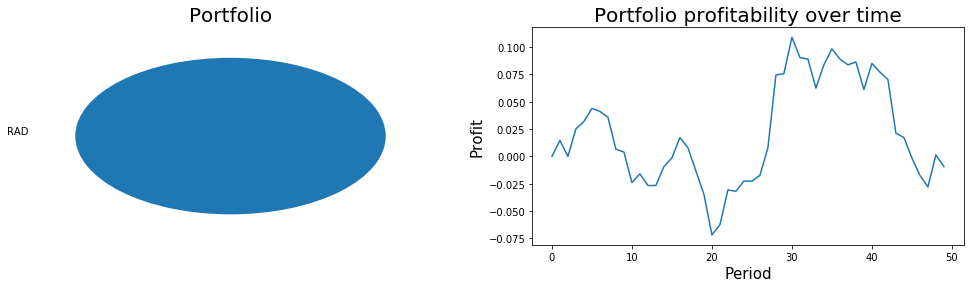

Profit on test data in 50 steps: -0.797872%
lambda = 0.100000


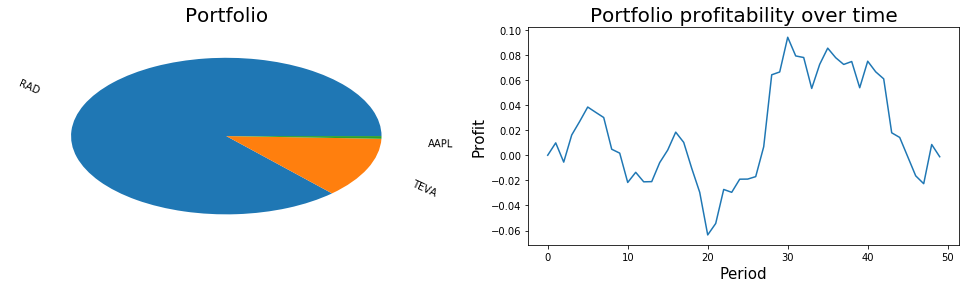

Profit on test data in 50 steps: 0.092718%
lambda = 0.500000


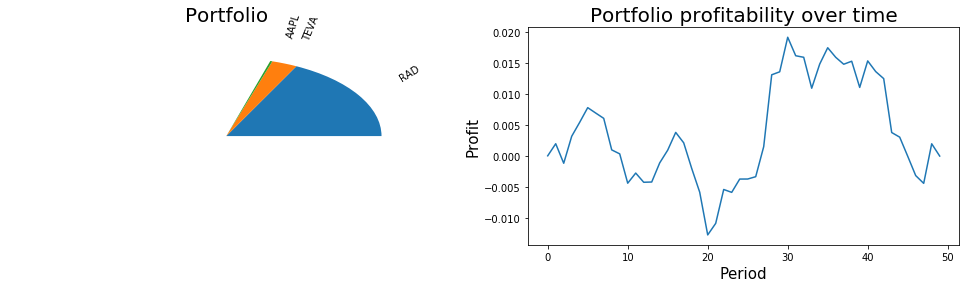

Profit on test data in 50 steps: 0.041085%
lambda = 1.000000


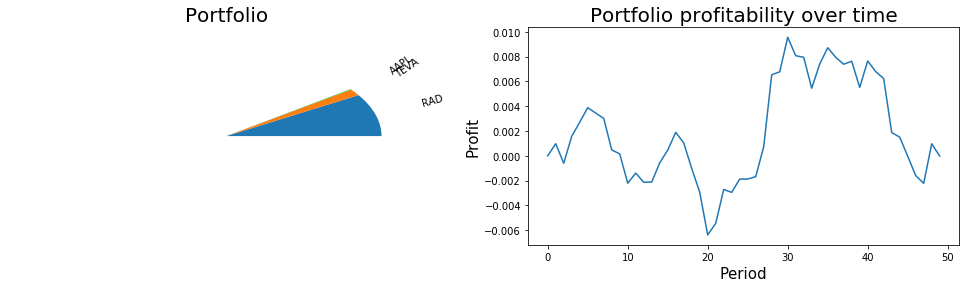

Profit on test data in 50 steps: 0.020543%
lambda = 2.000000


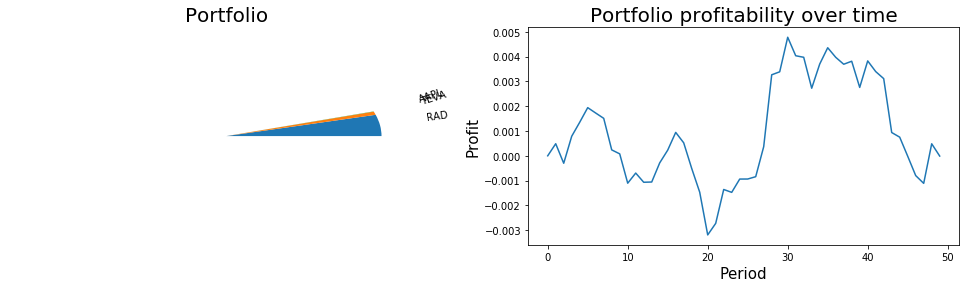

Profit on test data in 50 steps: 0.010253%


In [12]:
for l in LAMBDA_RANGE:
    print("lambda = %f" % l)
    opt_portfolio = get_optimal_portfoilio_for_known_predictions(prices, T-1, l, predictions)
    portfolio_info(opt_portfolio, PERIOD)

## Sparse Portfolios
Practical investing requires balancing portfolio **optimality** and **simplicity**!

* Managing large asset positions and transacting frequently is expensive and time-consuming
* Their **choice set** for investment opportunities **is massive** and includes exchange-traded funds (ETFs), mutual funds, and thousands of individual stocks.

##### How does one invest optimally while keeping the simplicity (sparsity) of a portfolio in mind? 
**Answer**: for example $l_1$ penalizing
$$L = \frac{1}{2} w^T \Sigma w - w^T \mu + \lambda \|w\|_1$$

This problem can reformulated to the form of **standard** sparse **regression** loss functions:
$$L = \frac{1}{2} \left \|L^T  w - L^{-1} \mu \right\|_2^2 + \lambda  \| w\|_1$$
where $\Sigma = L L^T$ $-$ Cholesky decomposition

### Proof:
\begin{align}
L &= \frac{1}{2} w^T \Sigma w - w^T \mu + \lambda \|w\|_1 \sim\\
& \sim \frac{1}{2} \left(w - \Sigma^{-1} \mu \right)^T \Sigma \left(w - \Sigma^{-1} \mu \right) + \lambda \|w\|_1 = \\
& = \frac{1}{2} \left(w - L^{-T} L^{-1} \mu \right)^T L L^{T}  \left(w - L^{-T} L^{-1}  \mu \right) + \lambda \|w\|_1 = \\
& = \frac{1}{2} \left[ L^T \left(w - L^{-T} L^{-1} \mu \right) \right]^T  \left[ L^T \left(w - L^{-T} L^{-1} \mu \right) \right]+ \lambda \|w\|_1 = \\
& = \frac{1}{2} \left \|L^T  w - L^{-1} \mu \right\|_2^2 + \lambda  \| w\|_1
\end{align}

In [13]:
def get_optimal_portfolio(r, cov, l):
    x = cvx.Variable(N)
    L = np.linalg.cholesky(cov)
    
    objective = cvx.Minimize(0.5 * cvx.norm2(L.T @ x - np.linalg.inv(L) @r) ** 2 + l*cvx.norm1(x))
    constraints = [cvx.sum_entries(x) <= 1, x >= 0]
    prob = cvx.Problem(objective, constraints)
    obj = prob.solve()
    portfolio = np.copy(np.array(x.value).reshape(-1))
    return portfolio

lambda = 0.010000


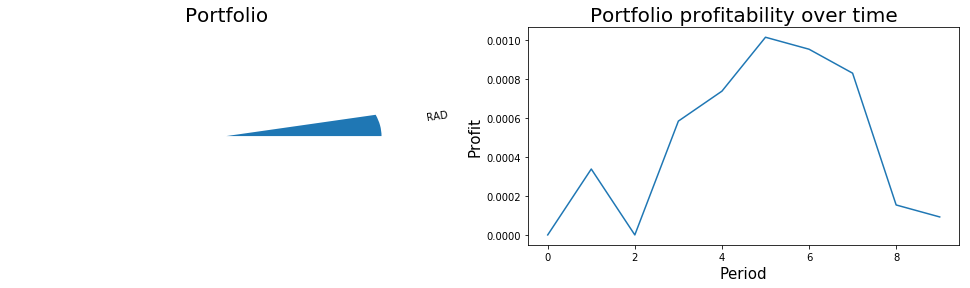

Profit on test data in 10 steps: -0.055288%
lambda = 0.000100


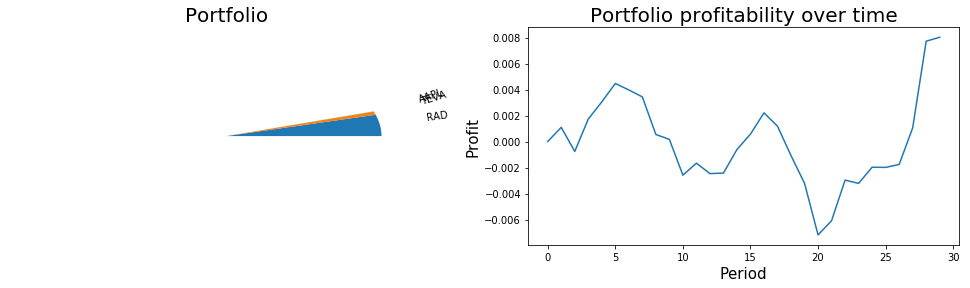

Profit on test data in 30 steps: 1.122339%
lambda = 0.000100


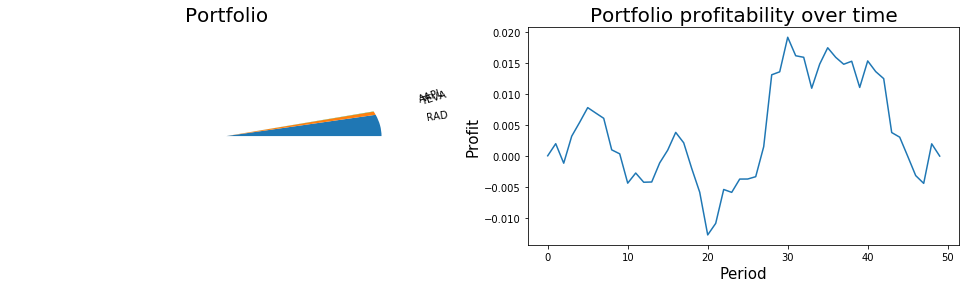

Profit on test data in 50 steps: 0.039966%
lambda = 0.000100


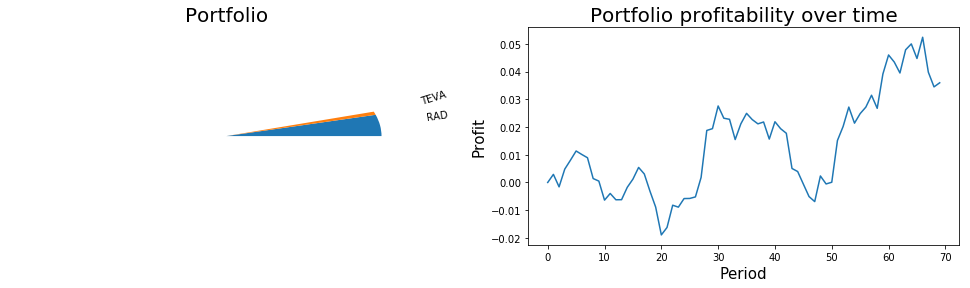

Profit on test data in 70 steps: 3.462065%
lambda = 0.000100


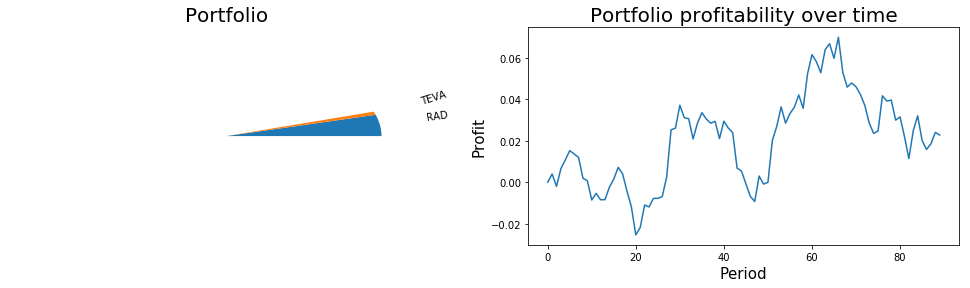

Profit on test data in 90 steps: 1.730222%


In [15]:
PERIOD_RANGE = [10, 30, 50, 70, 90]
LAMBDA_RANGE = [0.0001, 0.001, 0.01]
for PERIOD in PERIOD_RANGE:
    predictions = pred_arima(to_ts(data), PERIOD)
    
    profit_best = - np.inf
    for l in LAMBDA_RANGE:
        opt_portfolio_n = get_optimal_portfoilio_for_known_predictions(prices, T-1, l, predictions)
        profit_n = count_real_profit(opt_portfolio_n, PERIOD) * 100
        if profit_n > profit_best:
            profit_best = profit_n
            opt_portfolio_best = opt_portfolio_n
            lambda_best = l
    
    print("lambda = %f" % lambda_best)
    portfolio_info(opt_portfolio_best, PERIOD)